<a href="https://colab.research.google.com/github/castudil/Machine-Learning/blob/main/S14-Anomaly-Detection/time_series_anomaly_detection_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy : 1.25.2
pandas: 2.0.3
torch : 2.3.0+cu121



In [5]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [6]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 29.4MB/s]


In [7]:
!unzip -qq ECG5000.zip

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print(f'Device: {device}')

Device: cpu


The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [11]:
from scipy.io import arff ## for loading arff files
## for more info https://www.geeksforgeeks.org/reading-an-arff-file-to-pandas-dataframe/
with open('ECG5000_TRAIN.arff') as f:
  arff_file = arff.loadarff(f)
  train = pd.DataFrame(arff_file[0])


with open('ECG5000_TEST.arff') as f:
  arff_file = arff.loadarff(f)
  test = pd.DataFrame(arff_file[0])

train.shape,test.shape

((500, 141), (4500, 141))

In [12]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [14]:
# prompt: concatenate train and test and store in df. then, shufle df. finally head df

import pandas as pd

# concatenate train and test
# ignore_index=True ensures that the resulting DataFrame will have a new continuous index, rather than preserving the indices from the original DataFrames.
# By default, sample does this without replacement, meaning that each row will appear only once in the resulting DataFrame.
df = pd.concat([train, test], ignore_index=True)
df = df.sample(frac=1.0, random_state=RANDOM_SEED)
df.head()


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1501,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2586,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2653,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
1055,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
705,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


In [15]:
df.shape

(5000, 141)

We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [16]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [17]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [18]:
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

Let's plot the results:

<ipython-input-25-687bd7a1e9b2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="hls")


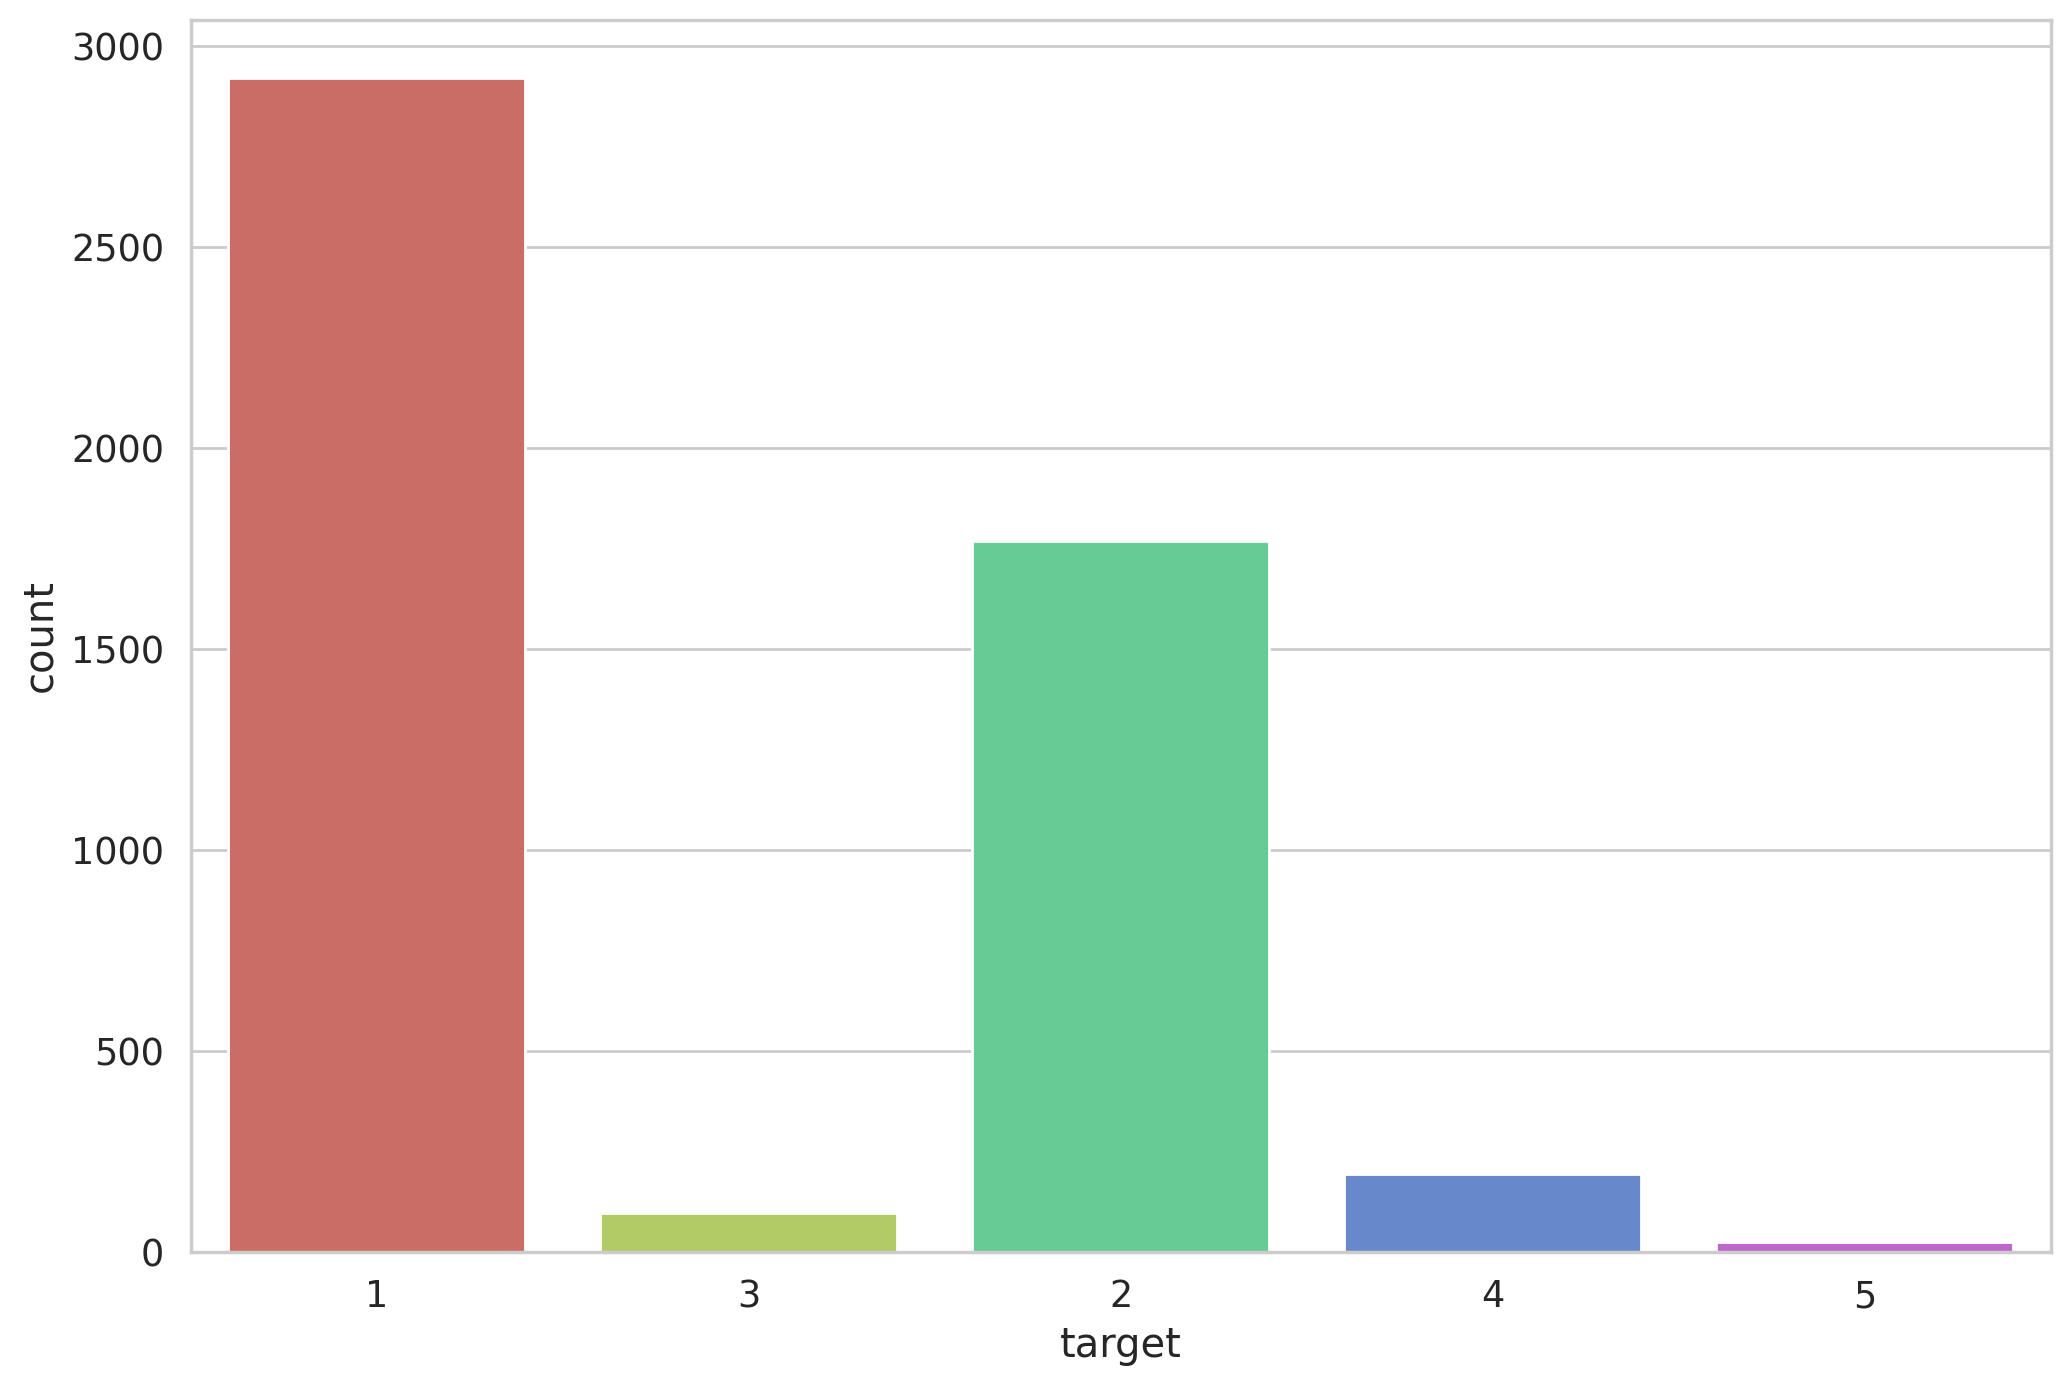

In [25]:
# prompt: plot a bar plot of the target variable. Target in increasing order. use nice colors for each bar

import matplotlib.pyplot as plt
sns.countplot(x='target', data=df, order=df['target'].value_counts().index, palette='hls')
plt.show()


The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class.

The plot_time_series_class function is designed to plot a time series data with a smoothing effect and show the variation around the smoothed line.

•data: The time series data to be plotted.
•class_name: The title to be given to the plot, usually the name of the class or category of the data.
•ax: The Axes object where the plot will be drawn.
•n_steps: The window size for the rolling mean and standard deviation, with a default value of 10.






In [26]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data) ## The input data is converted into a Pandas DataFrame, which allows for easy manipulation using Pandas functions.

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

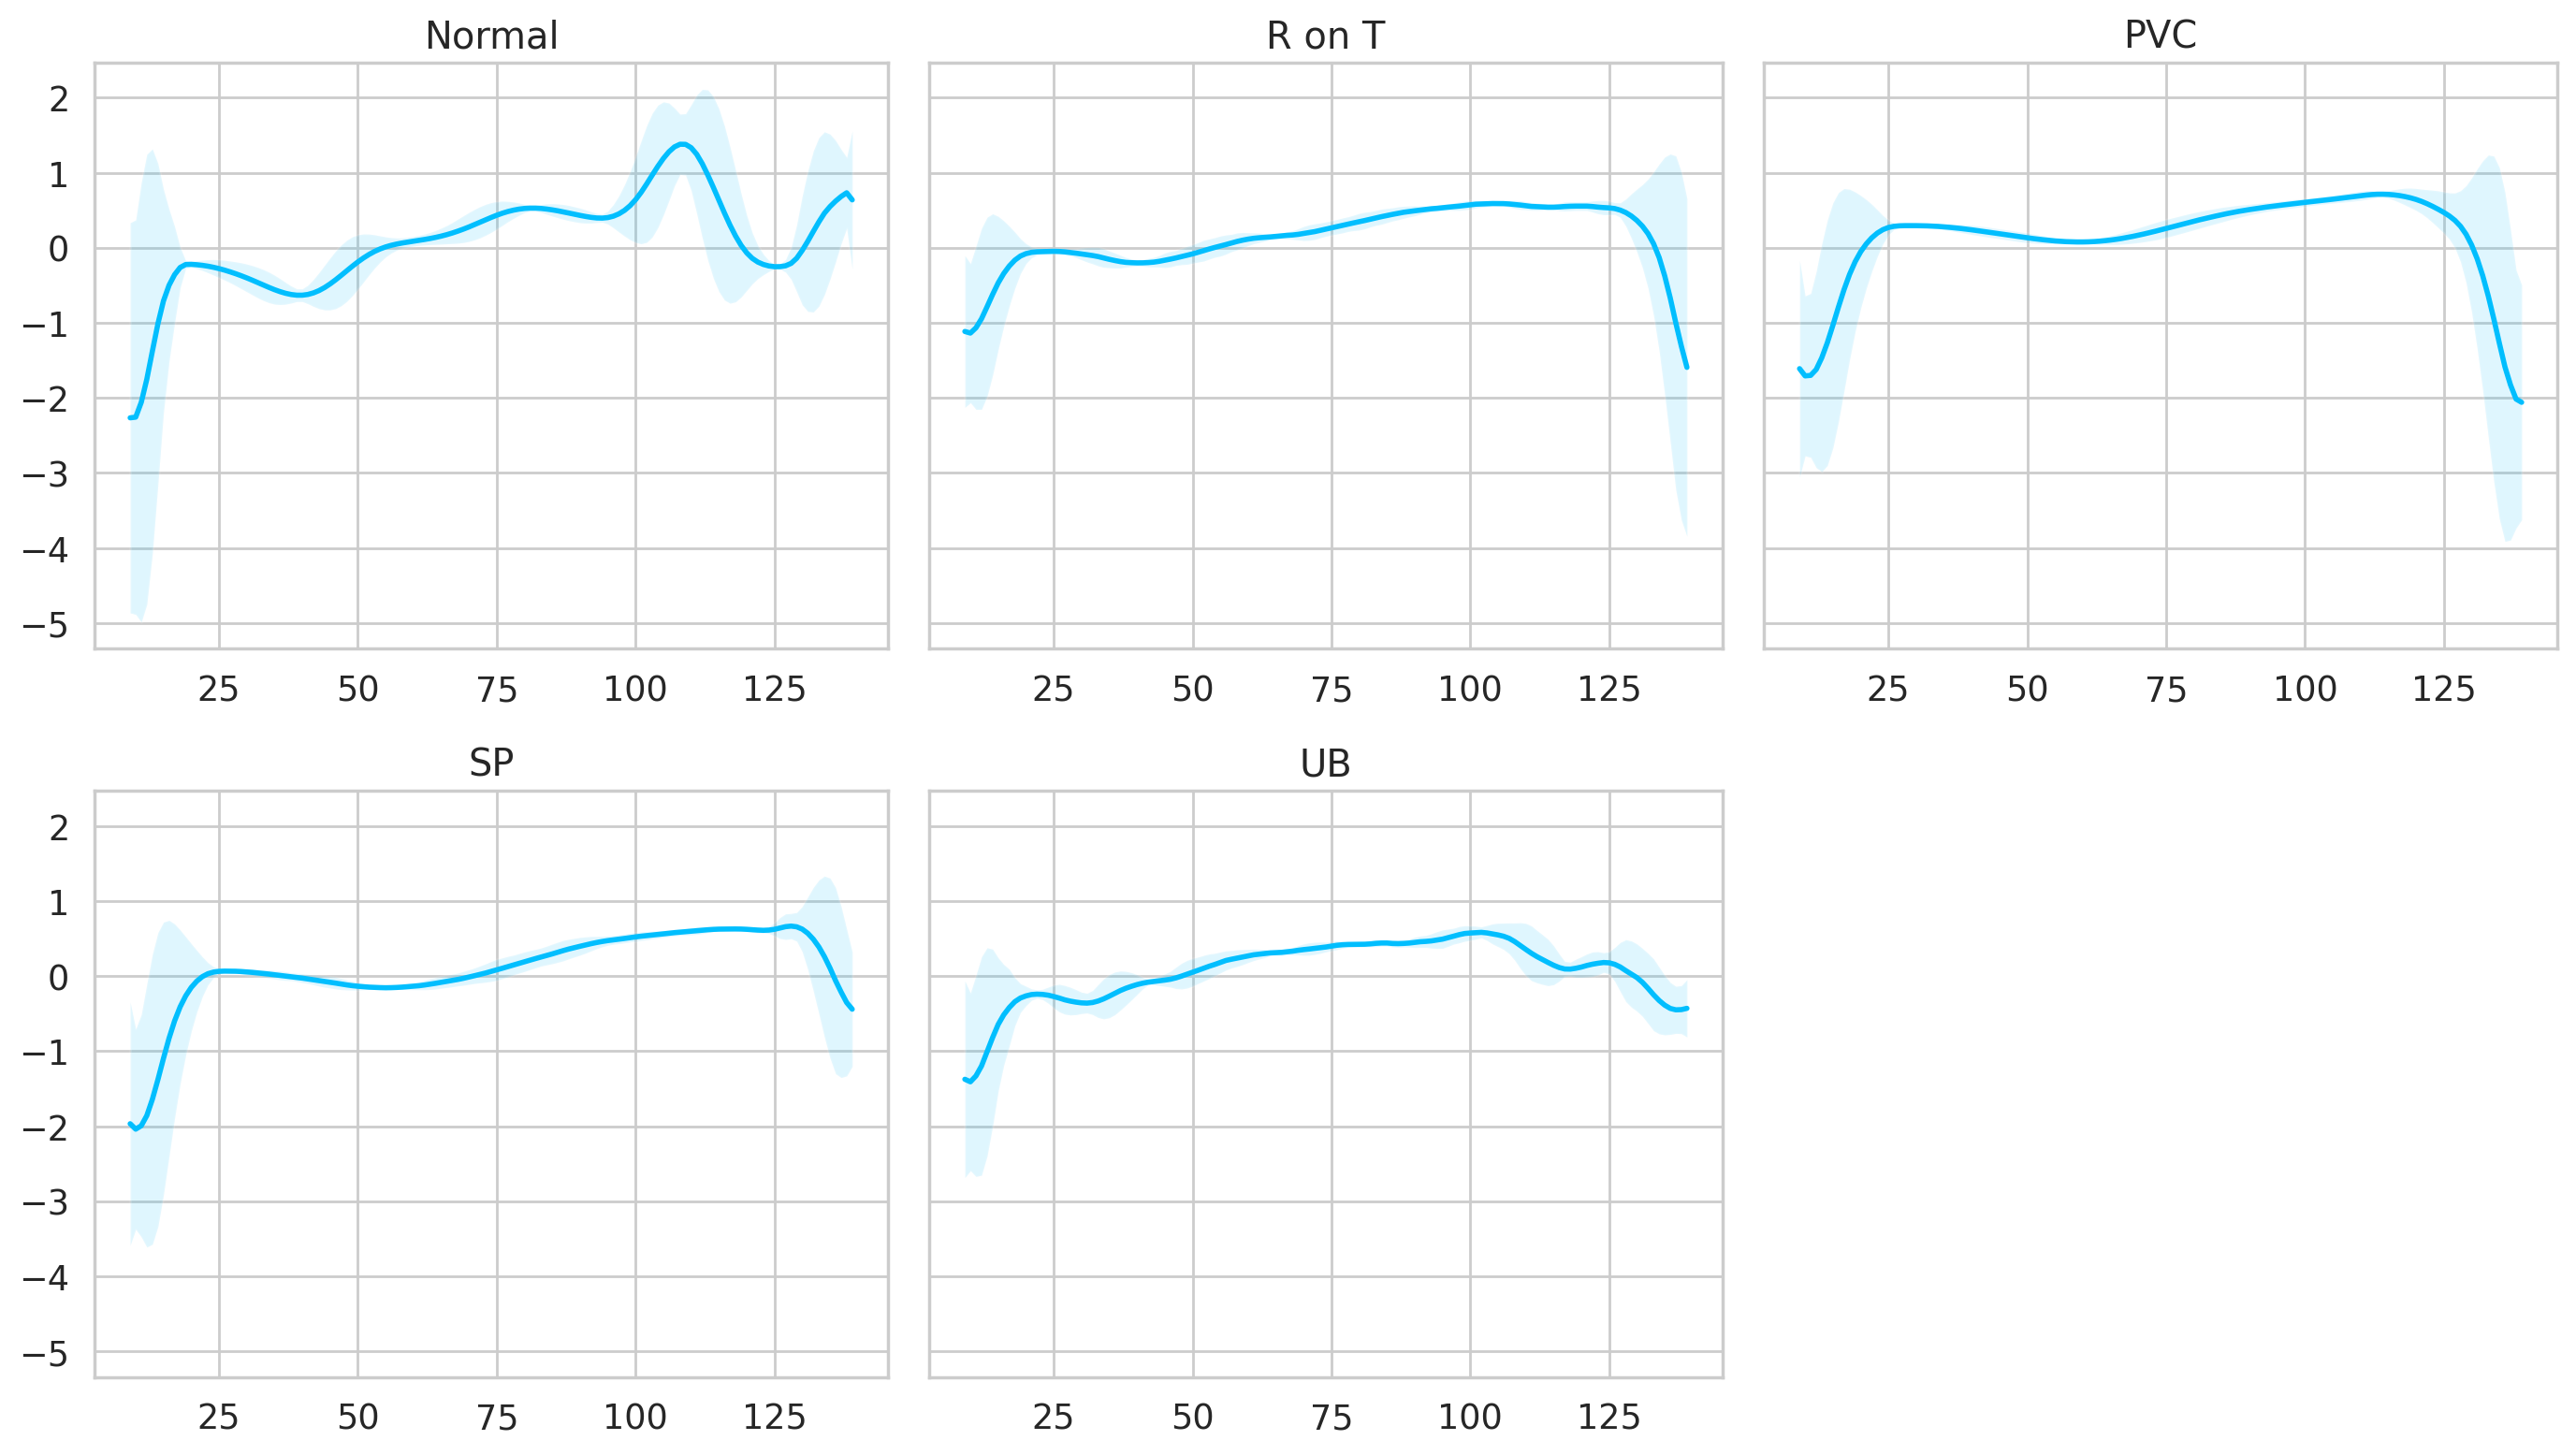

In [27]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder


Detectar anomalías en datos de electrocardiograma (ECG) usando un autoencoder implica entrenar el autoencoder en datos de ECG normales (sin anomalías) y luego usar su capacidad para reconstruir estos datos. Las anomalías se detectan cuando la reconstrucción del autoencoder no es precisa, indicando que la entrada es significativamente diferente de los datos normales.

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

In [33]:
# prompt: print the type of the first element of  target

print(type(df['target'][0]))


<class 'bytes'>


In [34]:
# prompt: change the type of the variable of target from bytes to string

df['target'] = df['target'].astype(str)


In [36]:
# prompt: show the python version

!python --version


Python 3.10.12


In [35]:
# prompt: from DF select all instances that are NORMAL

normal_df = df[df.target == str(CLASS_NORMAL)]
normal_df.shape

(2919, 141)

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [37]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [38]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [39]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [40]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [41]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [42]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [43]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [44]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [47]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

Let's write a helper function for our training process:

In [45]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [48]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 63.83245572617149 val loss 55.98739161833154


KeyboardInterrupt: 

NameError: name 'history' is not defined

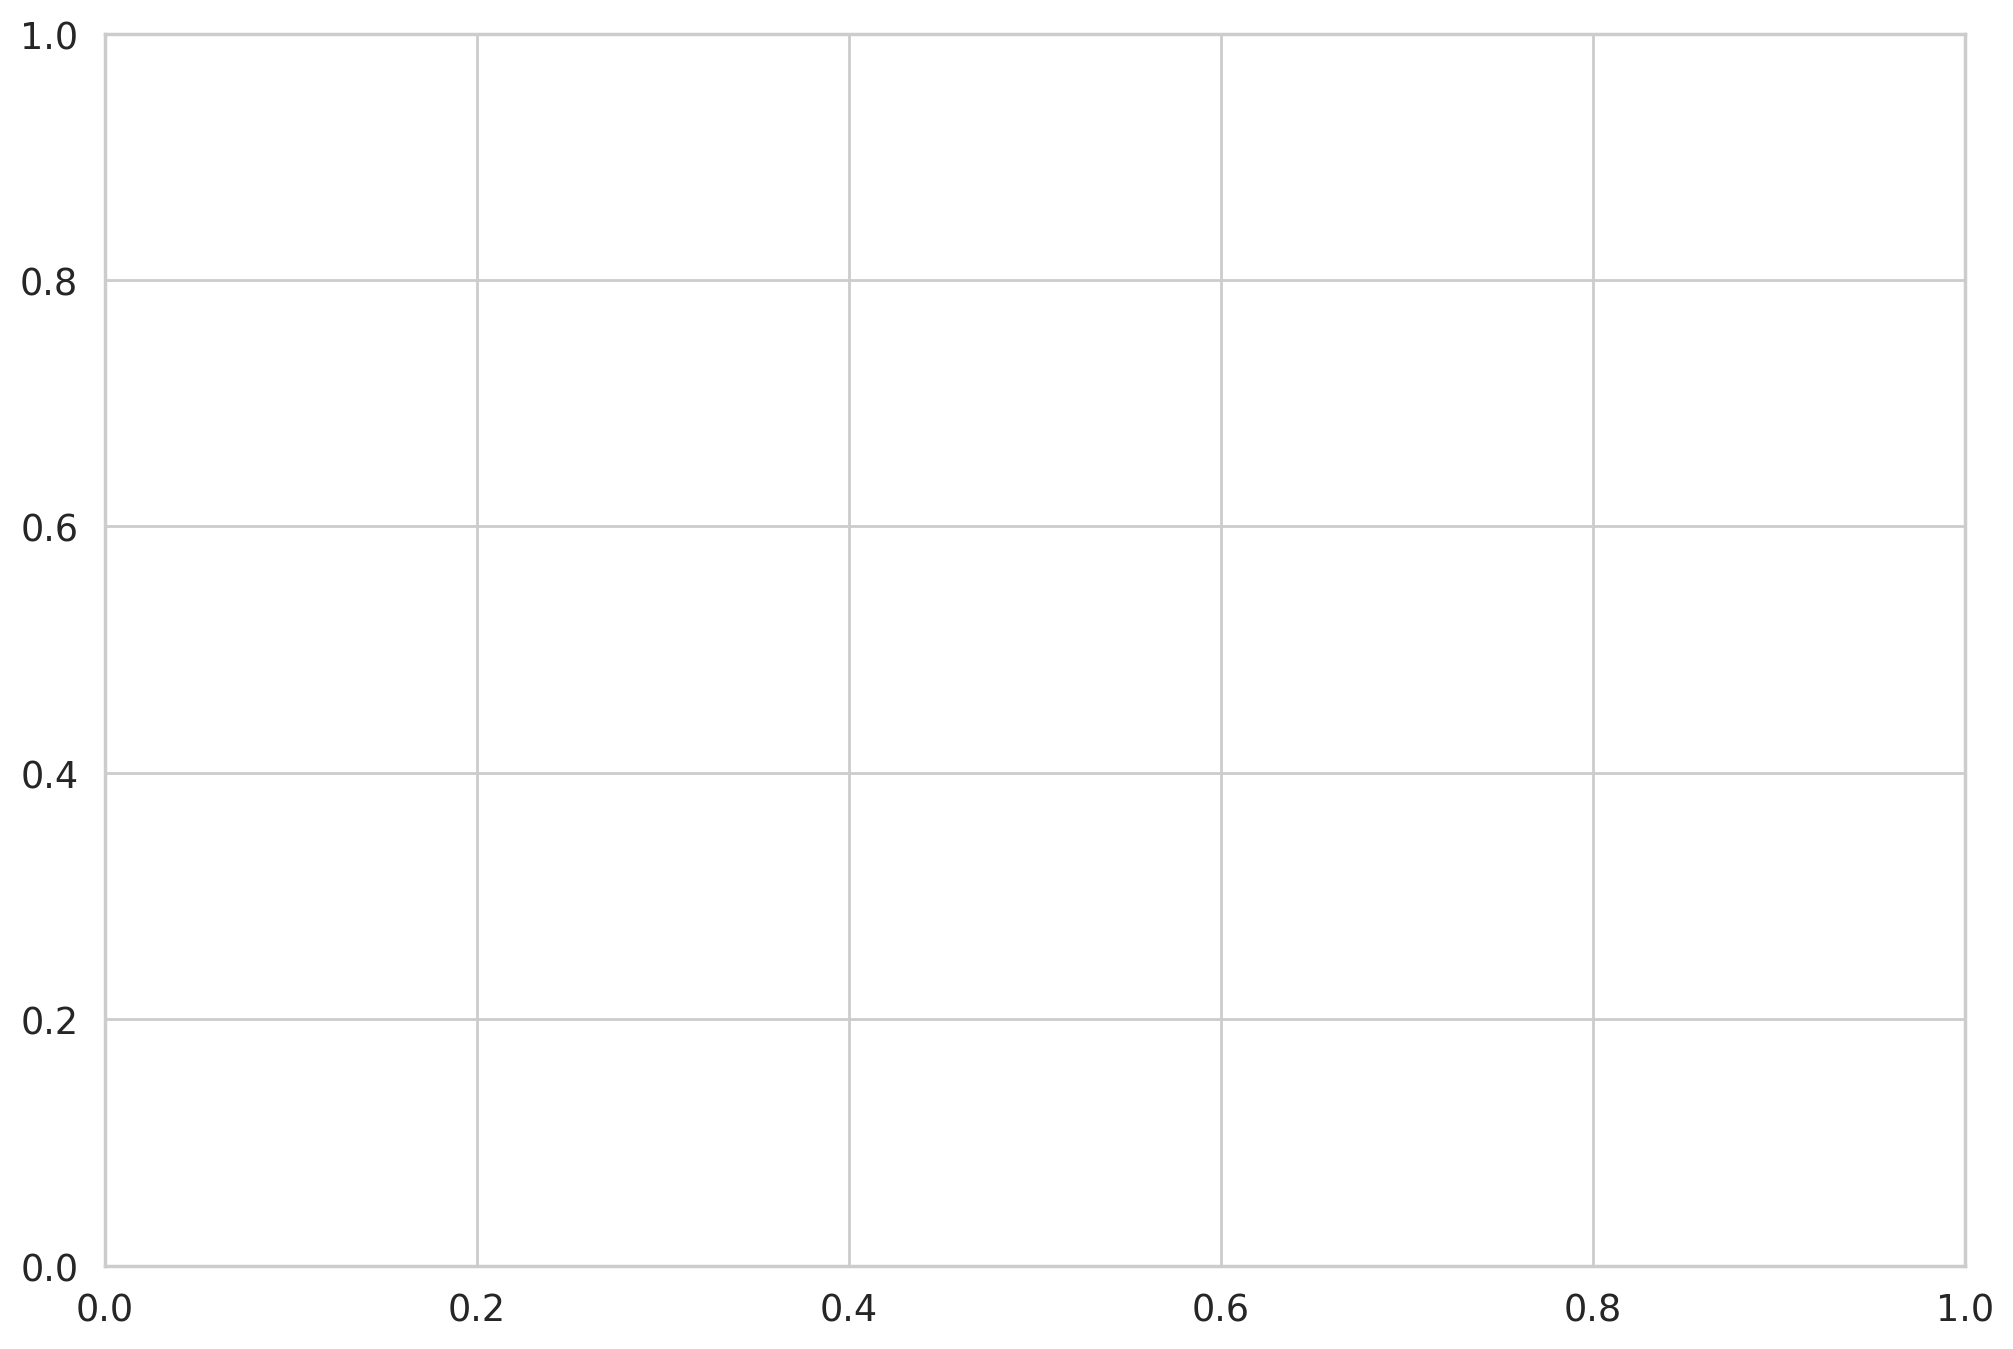

In [53]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [52]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('model.pth',map_location=torch.device('cpu'))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
100% 3.98M/3.98M [00:00<00:00, 45.3MB/s]


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1113: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1113: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [54]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

<ipython-input-55-b1e9518eed74>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


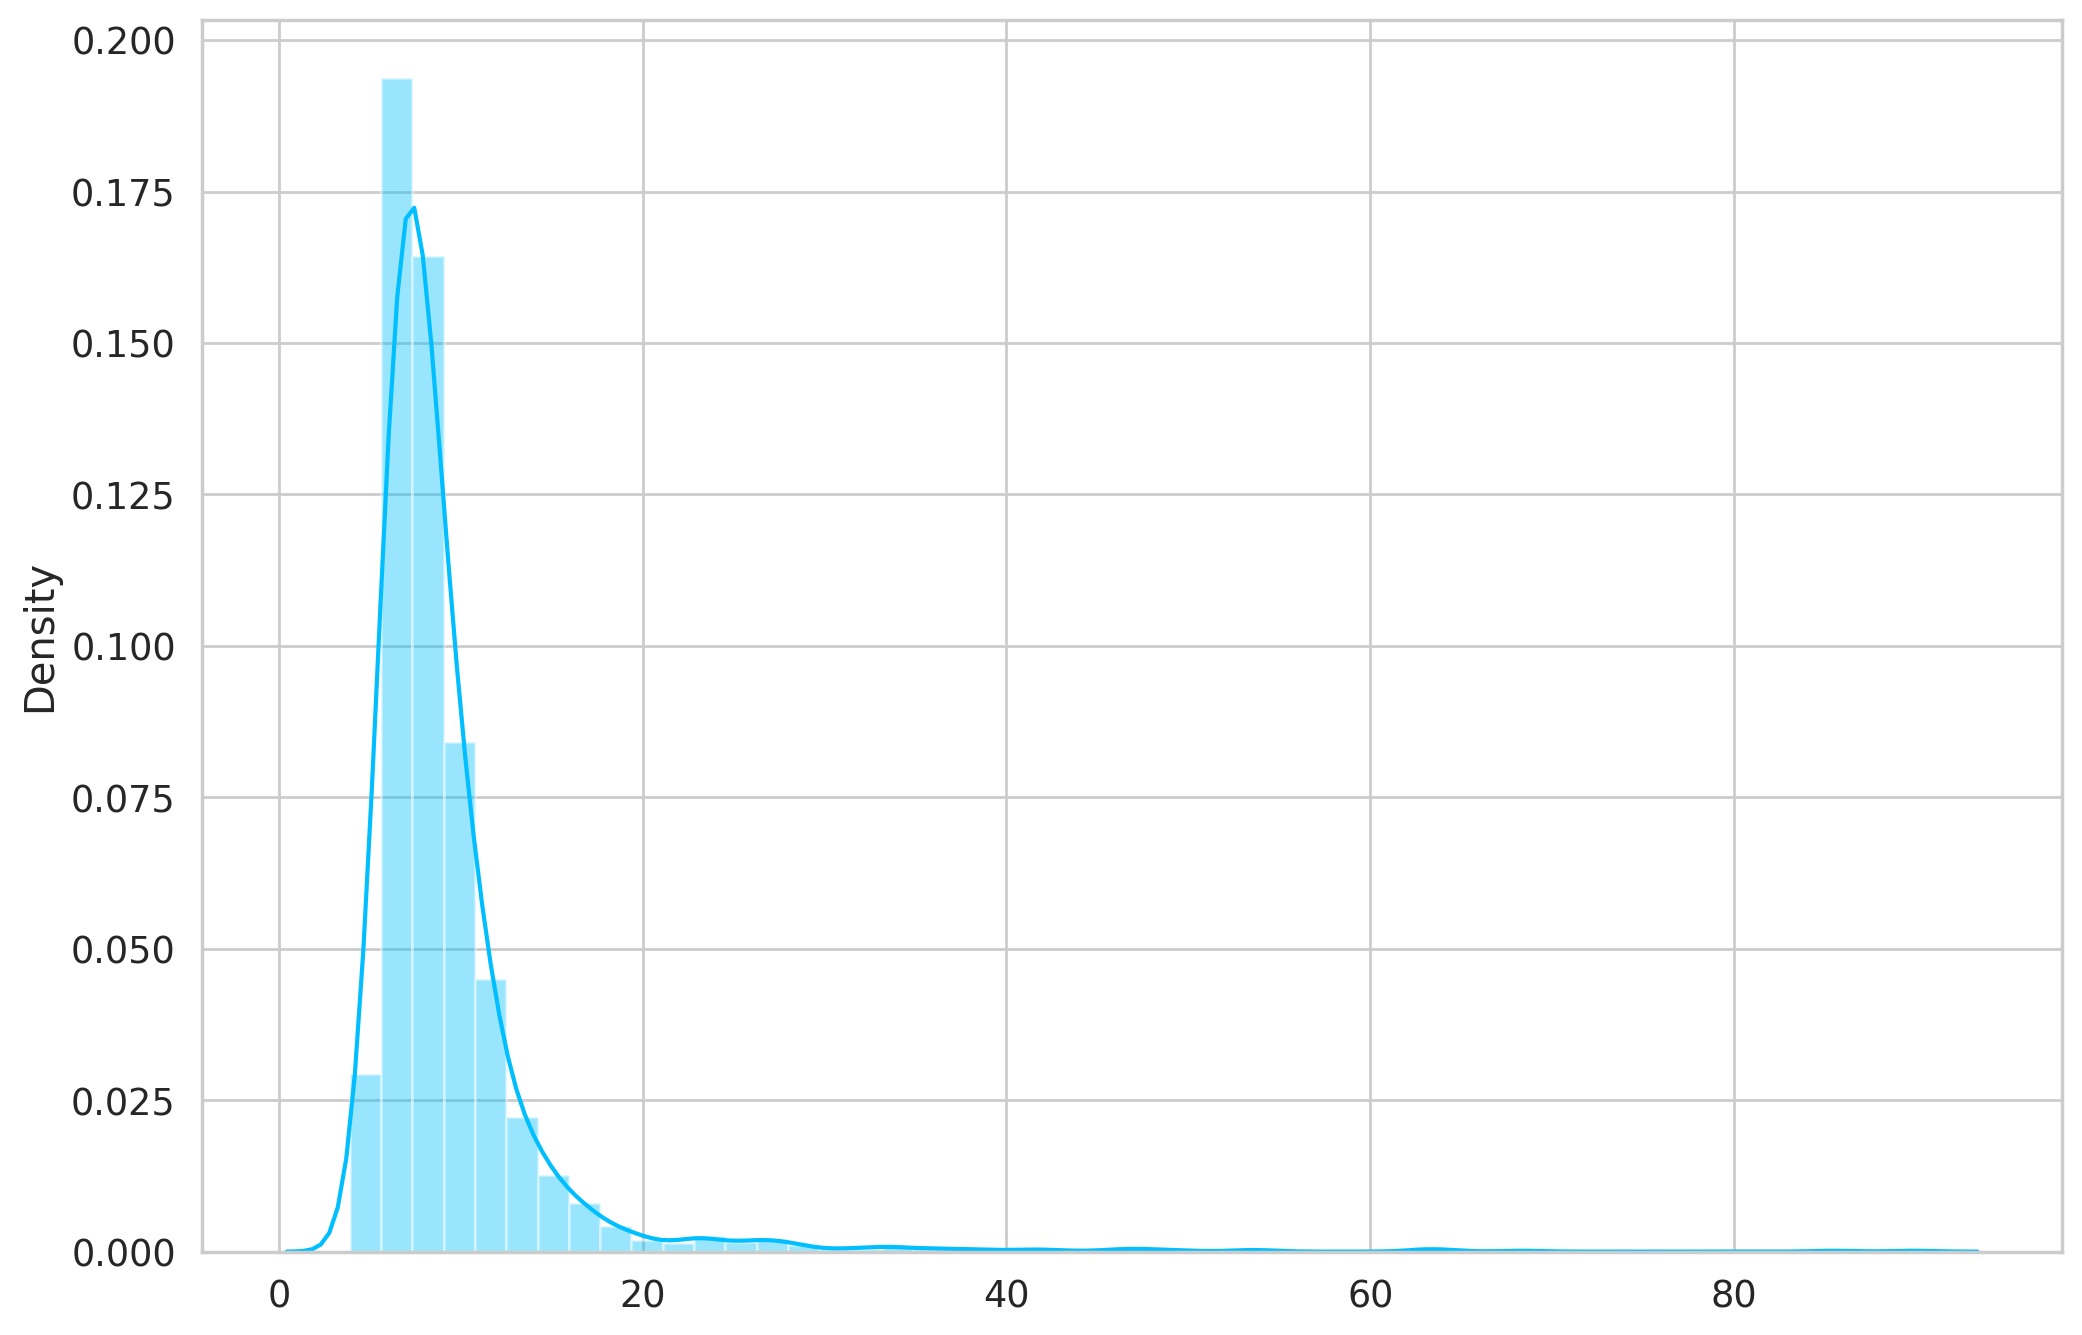

In [55]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [56]:
THRESHOLD = 26

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

<ipython-input-58-ed53989f8e41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


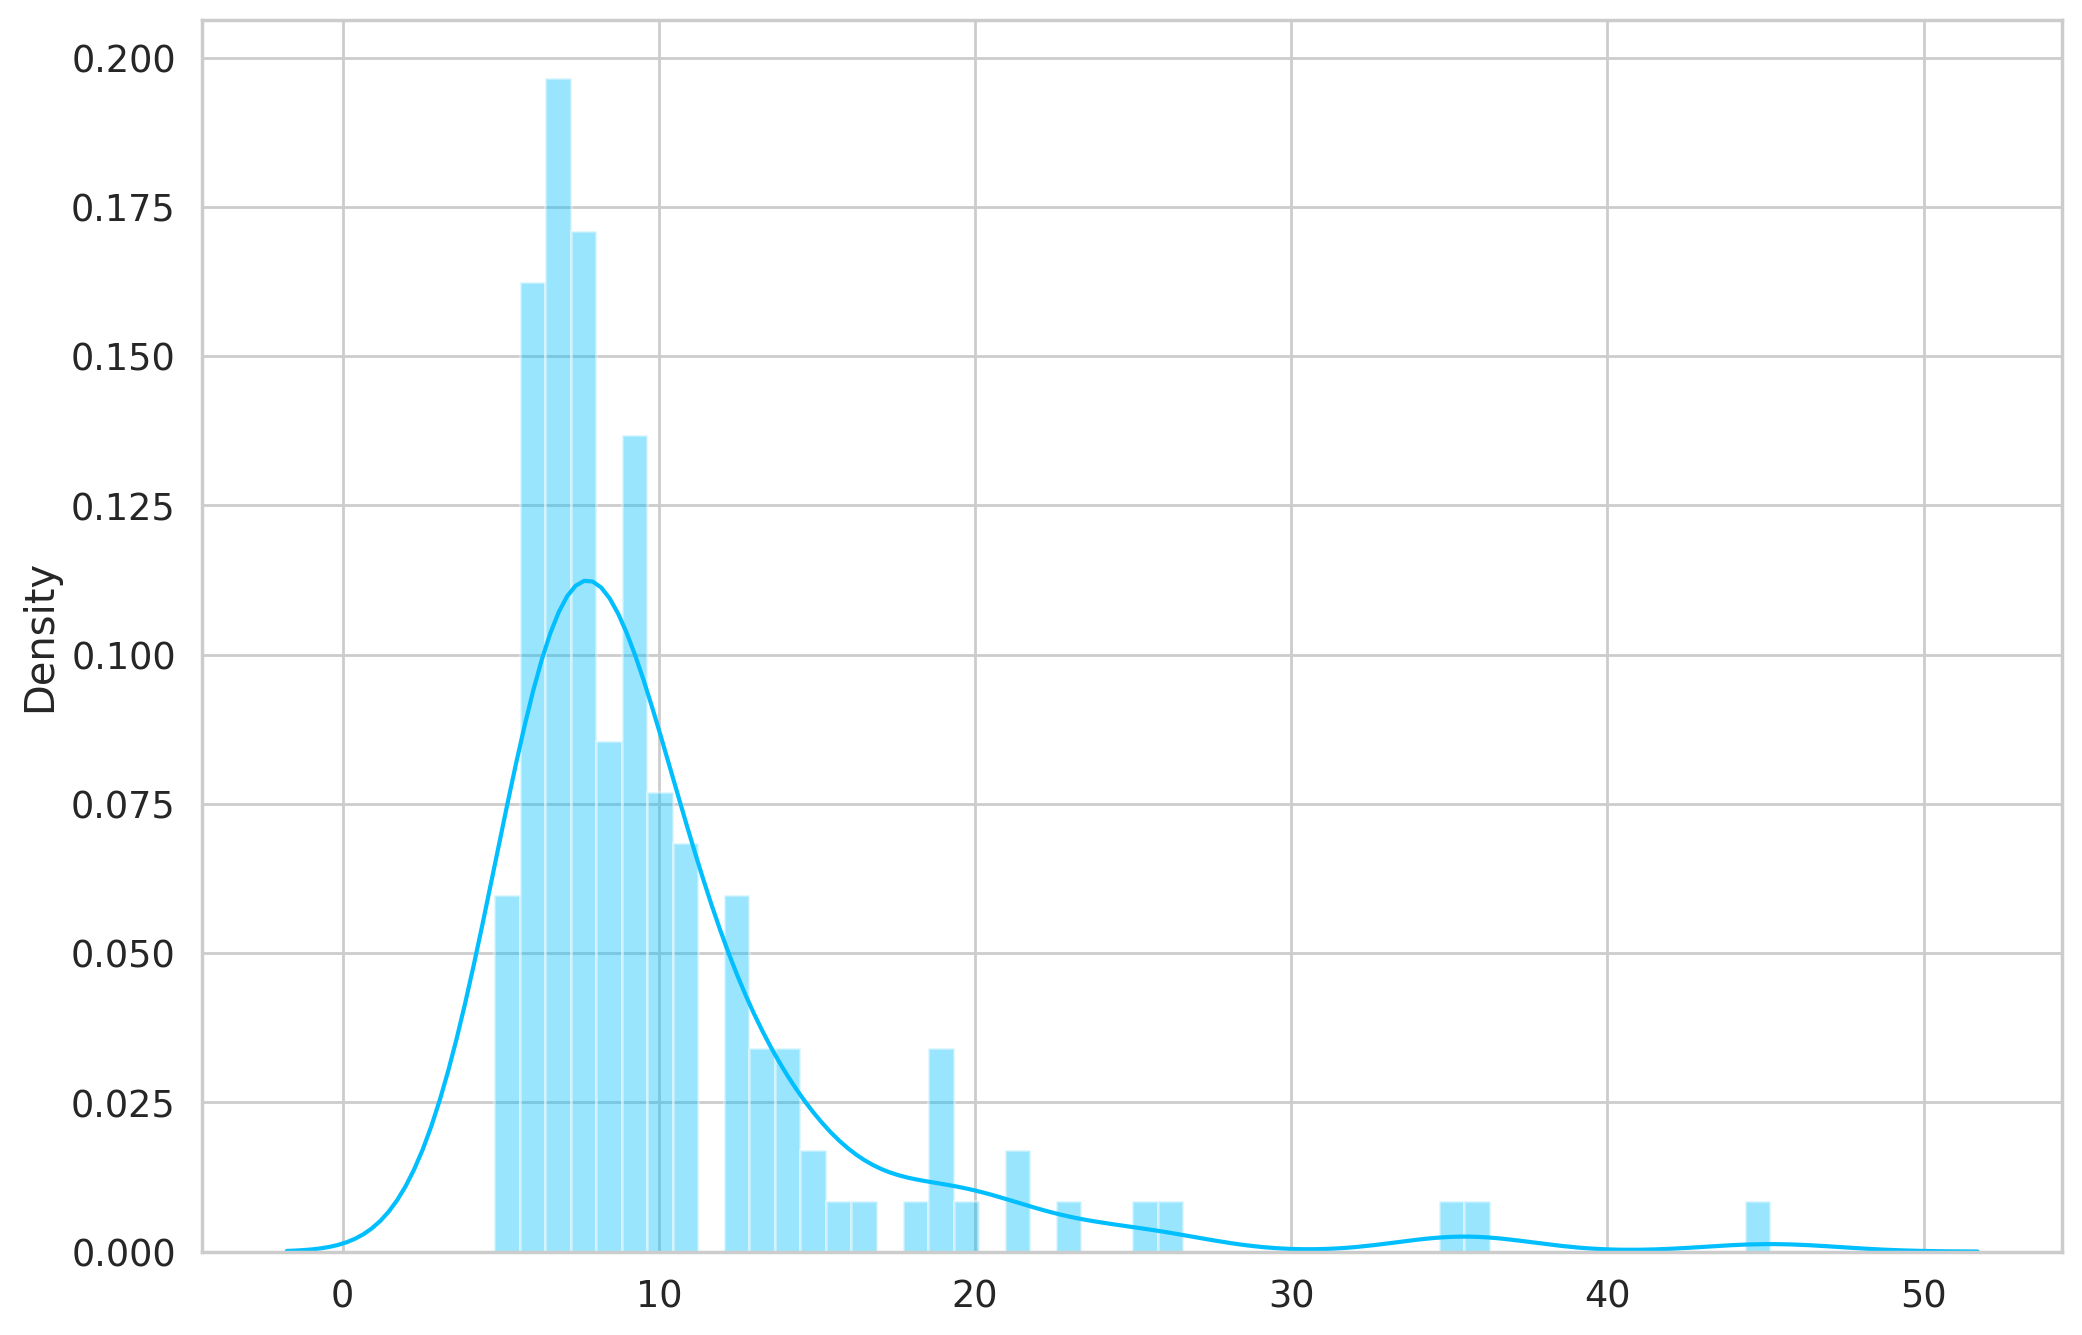

In [58]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [59]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 142/145


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

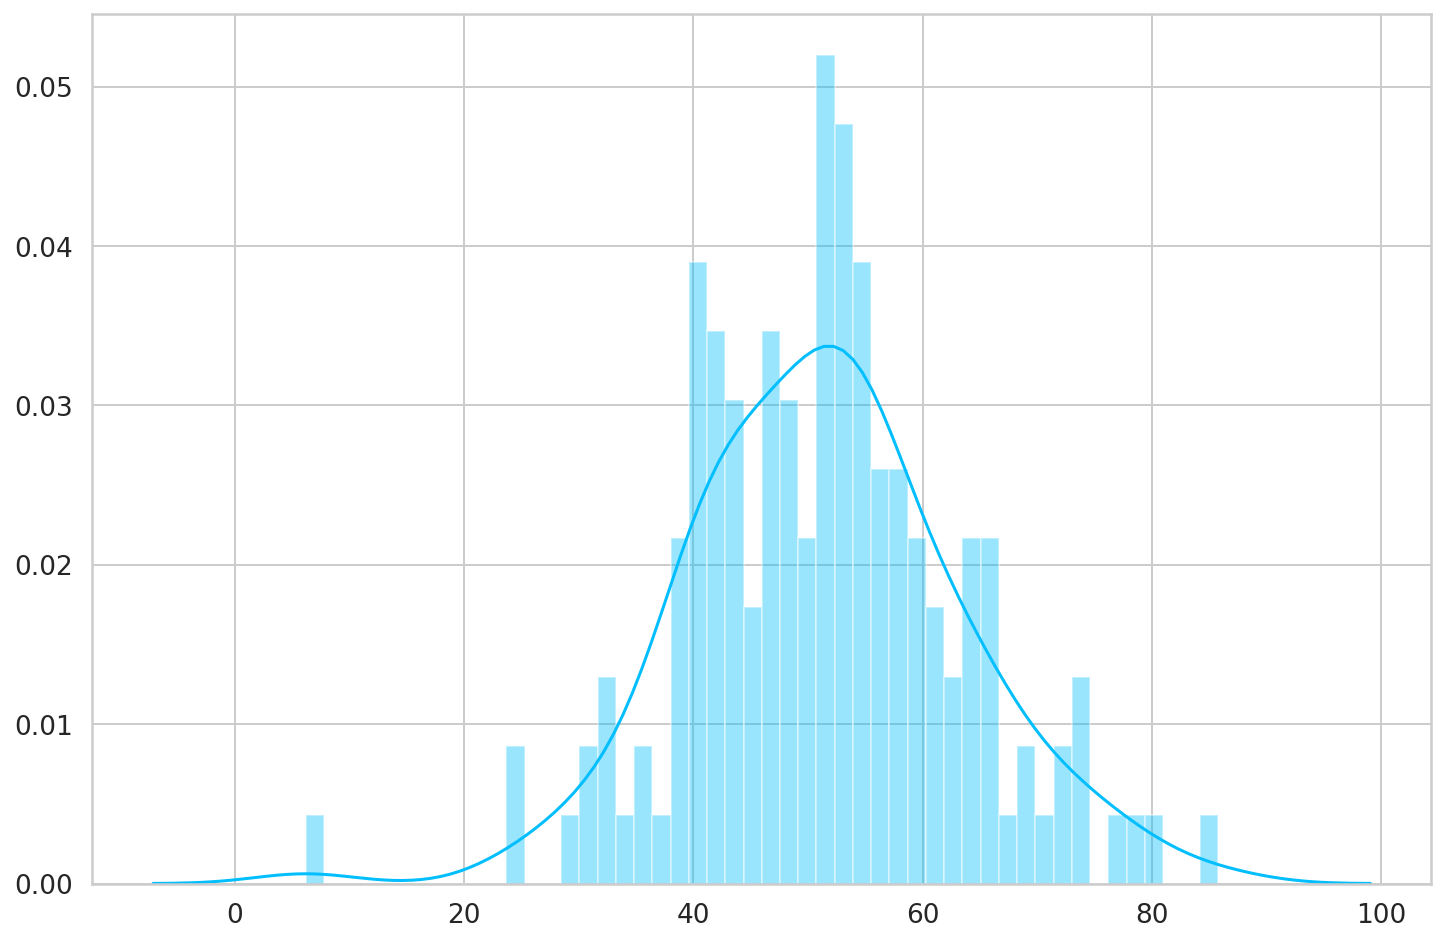

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 142/145


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

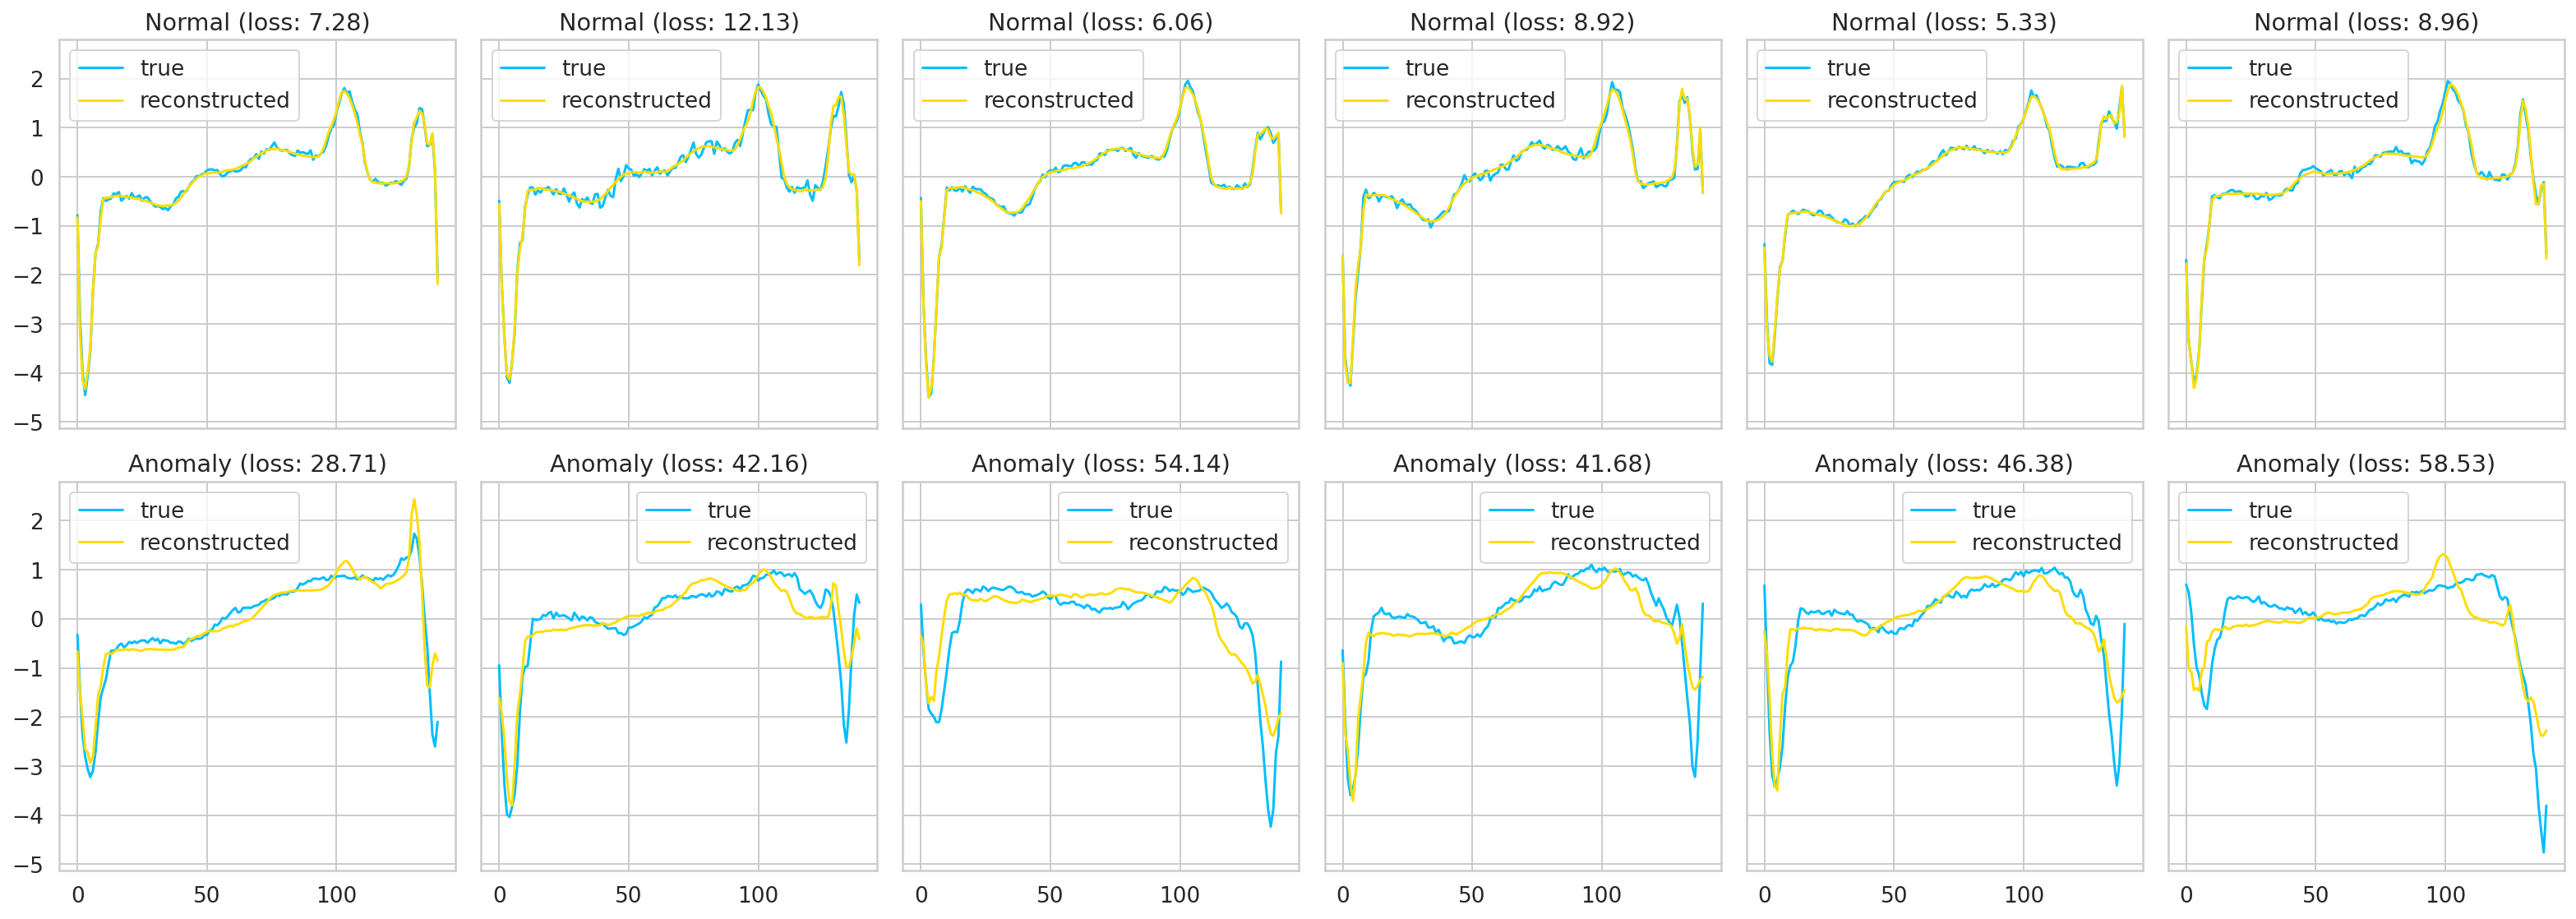

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)